In [0]:
# Import Libraries
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, from_json, split, regexp_replace, when, size,
    from_unixtime, expr, date_format, to_timestamp, lit, sha2
)
from pyspark.sql.types import StructType, StructField, StringType
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pandas.plotting import table

In [0]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("JSONImport") \
    .master("local[*]") \
    .getOrCreate()

In [0]:
# Specify the path to the JSON file
file_path = "/FileStore/tables/cc_sample_transaction.json"

In [0]:
# Read JSON file into a DataFrame
df = spark.read.json(file_path)

In [0]:
# Define schemas for nested JSON structures
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

In [0]:
# Display the original DataFrame
print("Original DataFrame:")
df.show(n=100, truncate=False)
df.printSchema()

Original DataFrame:
+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+-------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+--------------------------------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                   |personal_detail                                                                                                                                                                                                      

In [0]:
# First level flattening - personal_detail
df_level1 = df.select(
    *[col(field.name) for field in df.schema.fields if field.name != "personal_detail"],
    from_json(col("personal_detail"), personal_detail_schema).alias("personal_detail_struct")
)

In [0]:
# Extract all fields from personal_detail_struct
df_level2 = df_level1.select(
    *[col(field.name) for field in df_level1.schema.fields if field.name != "personal_detail_struct"],
    col("personal_detail_struct.person_name").alias("person_name"),
    col("personal_detail_struct.gender").alias("gender"),
    col("personal_detail_struct.address").alias("address_json"),
    col("personal_detail_struct.lat").alias("lat"),
    col("personal_detail_struct.long").alias("long"),
    col("personal_detail_struct.city_pop").alias("city_pop"),
    col("personal_detail_struct.job").alias("job"),
    col("personal_detail_struct.dob").alias("dob")
)

In [0]:
# Flatten address
df_level3 = df_level2.select(
    *[col(field.name) for field in df_level2.schema.fields if field.name != "address_json"],
    from_json(col("address_json"), address_schema).alias("address_struct")
).select(
    *[col(field.name) for field in df_level2.schema.fields if field.name != "address_json"],
    col("address_struct.street").alias("street"),
    col("address_struct.city").alias("city"),
    col("address_struct.state").alias("state"),
    col("address_struct.zip").alias("zip")
)

In [0]:
# Clean person_name
cleaned_df = df_level3.withColumn(
    "person_name",
    regexp_replace(
        regexp_replace(
            regexp_replace(col("person_name"), 
                           "[!@#$%^&*()|/]", " "  # Replace specific unwanted special characters with space
            ),
            "[,]+", " "  # Replace commas with space
        ),
        "\\s+", " "  # Replace multiple spaces with a single space
    )
)

In [0]:
# Convert timestamp columns to human-readable format in UTC+8
timestamp_df = cleaned_df \
    .withColumn(
        "trans_date_trans_time",
        date_format(to_timestamp(col("trans_date_trans_time")), "yyyy-MM-dd HH:mm:ss.SSSSSS 'UTC+8'")
    ) \
    .withColumn(
        "merch_last_update_time",
        date_format(
            from_unixtime(col("merch_last_update_time").cast("double") / 1000), 
            "yyyy-MM-dd HH:mm:ss.SSSSSS 'UTC+8'"
        )
    ) \
    .withColumn(
        "merch_eff_time",
        date_format(
            from_unixtime(col("merch_eff_time").cast("double") / 1000000), 
            "yyyy-MM-dd HH:mm:ss.SSSSSS 'UTC+8'"
        )
    )

In [0]:
# Split person_name into first and last names and handle PII masking/hashing
final_df = (
    timestamp_df.withColumn("name_parts", split(col("person_name"), "\s+"))
    .withColumn("first", col("name_parts")[0])
    .withColumn(
        "last",
        when(size(col("name_parts")) > 1, expr("trim(name_parts[1])"))  # Trim to handle leading/trailing spaces
        .otherwise(None)
    )
    .withColumn(
        "cc_bic",
        when(
            (col("cc_bic") == "") | (col("cc_bic").isin("Null", "NA")),
            lit("NULL")
        ).otherwise(col("cc_bic"))
    )
    .withColumn("cc_num_hashed", sha2(col("cc_num"), 256))
    .withColumn("person_name_hashed", sha2(col("person_name"), 256))
    .drop("cc_num", "person_name")
    .withColumn("dob", regexp_replace(col("dob"), r"\d{4}-\d{2}-\d{2}", "XXXX-XX-XX"))
    .withColumn("street", regexp_replace(col("street"), r"\d+", "XXXX"))
    .select(
        "Unnamed: 0",
        "trans_date_trans_time",
        "cc_num_hashed",
        "merchant",
        "category",
        "amt",
        "first",
        "last",
        "gender",
        "street",
        "city",
        "state",
        "zip",
        "lat",
        "long",
        "city_pop",
        "job",
        "dob",
        "trans_num",
        "merch_lat",
        "merch_long",
        "is_fraud",
        "merch_zipcode",
        "merch_last_update_time",
        "merch_eff_time",
        "cc_bic"
    )
    .withColumn("amt", col("amt").cast("float"))  # Convert amt to float
    .withColumn("is_fraud", col("is_fraud").cast("int"))  # Convert is_fraud to int
)

In [0]:
# Show the final DataFrame with all rows displayed
print("Final Flattened DataFrame:")
final_df.show(n=100, truncate=False)
final_df.printSchema()

Final Flattened DataFrame:
+----------+--------------------------------+----------------------------------------------------------------+-------------------------------------------+-------------+------+-----------+----------+------+--------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+--------------------------------+--------------------------------+-----------+
|Unnamed: 0|trans_date_trans_time           |cc_num_hashed                                                   |merchant                                   |category     |amt   |first      |last      |gender|street                          |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |trans_num                       |merch_lat         |merch_long  

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = final_df.toPandas()

In [0]:
# Visualization
sns.set(style="whitegrid")

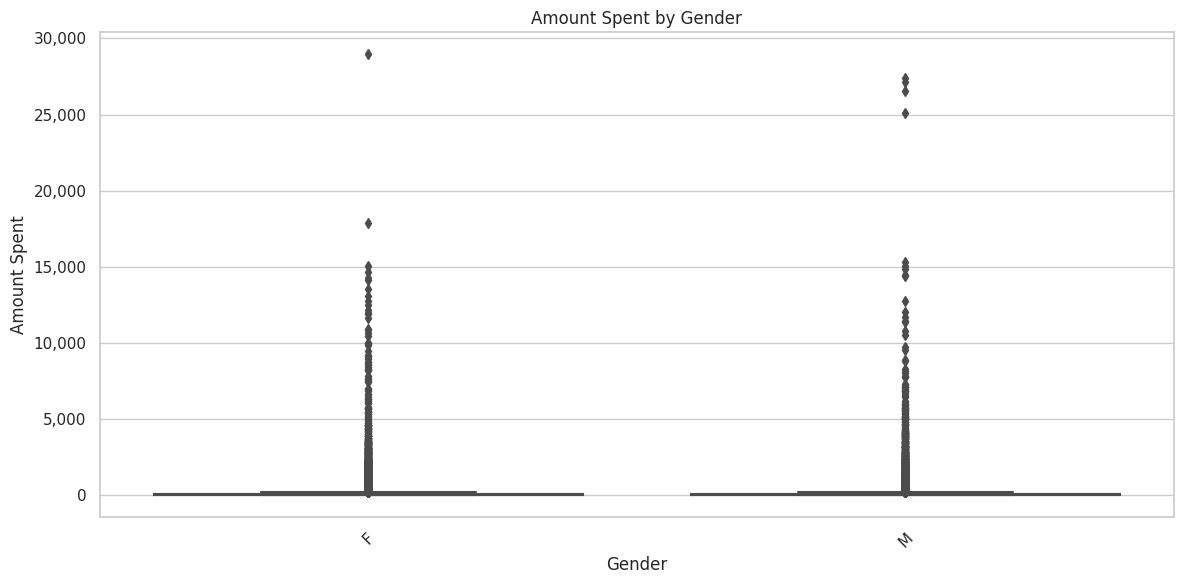

In [0]:
# Visualization 1: Amount Spent by Gender (Boxplot)

# Define the formatter function
def millions_formatter(x, pos):
    return f'{int(x):,}'

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='amt', data=pandas_df)

# Apply the formatter to y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Amount Spent by Gender')
plt.xlabel('Gender')
plt.ylabel('Amount Spent')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure labels fit
plt.show()

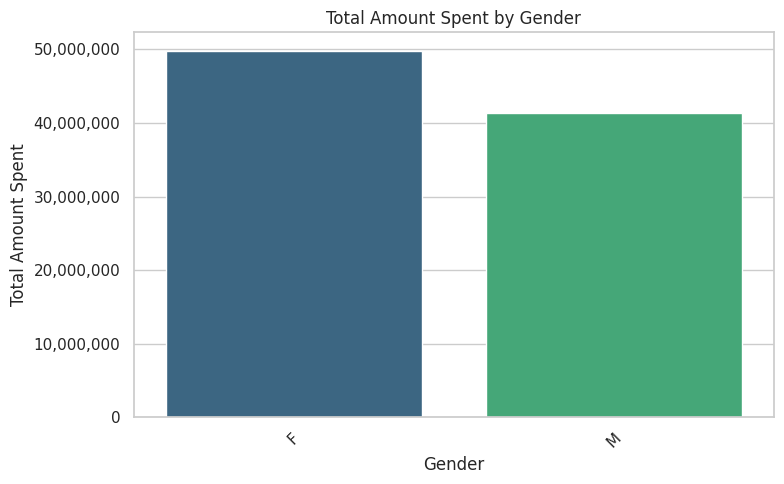

In [0]:
# Visualization 2: Amount Spent by Gender (Barplot)

# Calculate total transaction amount by gender
total_amt_by_gender = pandas_df.groupby('gender')['amt'].sum().reset_index()

# Define the formatter function
def millions_formatter(x, pos):
    return f'{int(x):,}'

# Create the barplot
plt.figure(figsize=(8, 5))
sns.barplot(x='gender', y='amt', data=total_amt_by_gender, palette='viridis')

# Apply the formatter to y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title('Total Amount Spent by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Amount Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

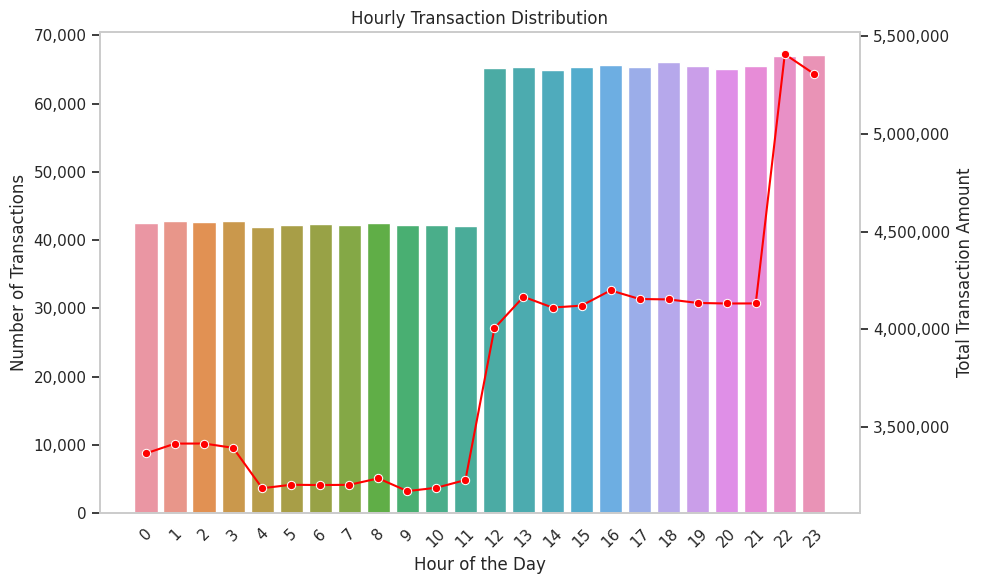

In [0]:
# Visualization 3: Hourly Transaction Distribution

# Convert the 'trans_date_trans_time' column to datetime if not already in datetime format
pandas_df['trans_date_trans_time'] = pd.to_datetime(pandas_df['trans_date_trans_time'])

# Calculate hourly transaction count and total amount
hourly_transactions = pandas_df.groupby(
    pandas_df['trans_date_trans_time'].dt.hour
).agg(
    transaction_count=('trans_num', 'count'),
    total_amount=('amt', 'sum')
).reset_index()

# Rename the index column to 'Hour'
hourly_transactions.rename(columns={'trans_date_trans_time': 'Hour'}, inplace=True)

# Plotting with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for transaction count on primary y-axis
sns.barplot(x='Hour', y='transaction_count', data=hourly_transactions, ax=ax1)
ax1.set_ylabel('Number of Transactions')
ax1.set_xlabel('Hour of the Day')
ax1.set_title('Hourly Transaction Distribution')
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for total transaction amount
ax2 = ax1.twinx()
sns.lineplot(x='Hour', y='total_amount', data=hourly_transactions, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Total Transaction Amount')

# Disable grid lines
ax1.grid(False)
ax2.grid(False)

# Set y-axis formatting to include thousands separator for clarity
from matplotlib.ticker import FuncFormatter
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

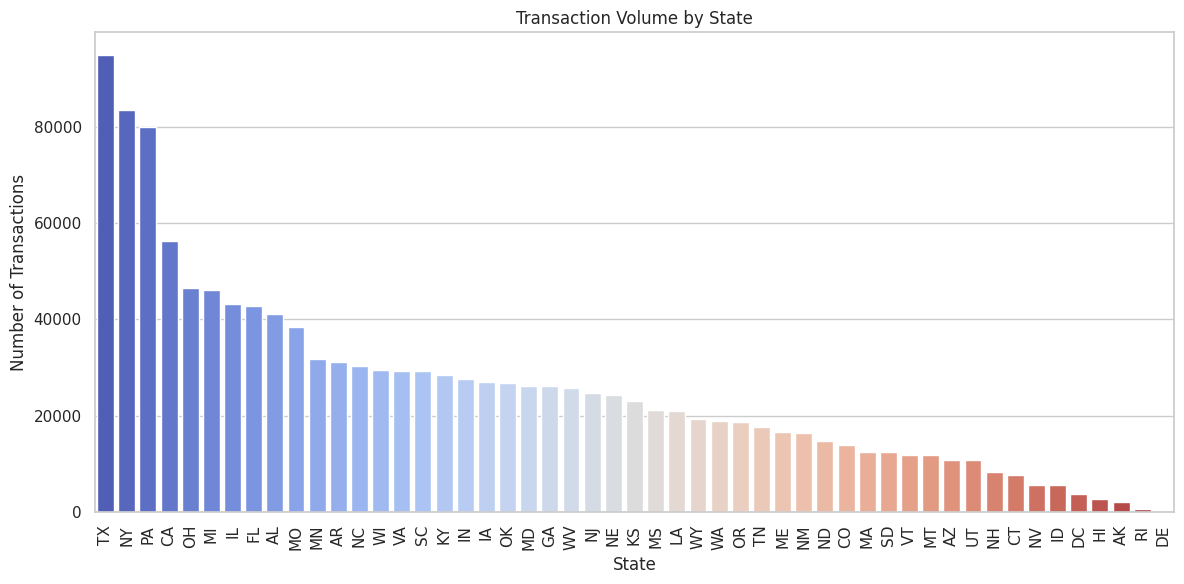

In [0]:
# Visualization 4: Transaction Volume by State

# Calculate transaction volume by state
state_transactions = pandas_df.groupby('state')['trans_num'].count().reset_index()
state_transactions.columns = ['State', 'Number of Transactions']

# Sort by number of transactions (descending)
state_transactions = state_transactions.sort_values(by='Number of Transactions', ascending=False)

# Plot transaction volume by state
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Number of Transactions', data=state_transactions, palette='coolwarm')
plt.title('Transaction Volume by State')
plt.xlabel('State')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

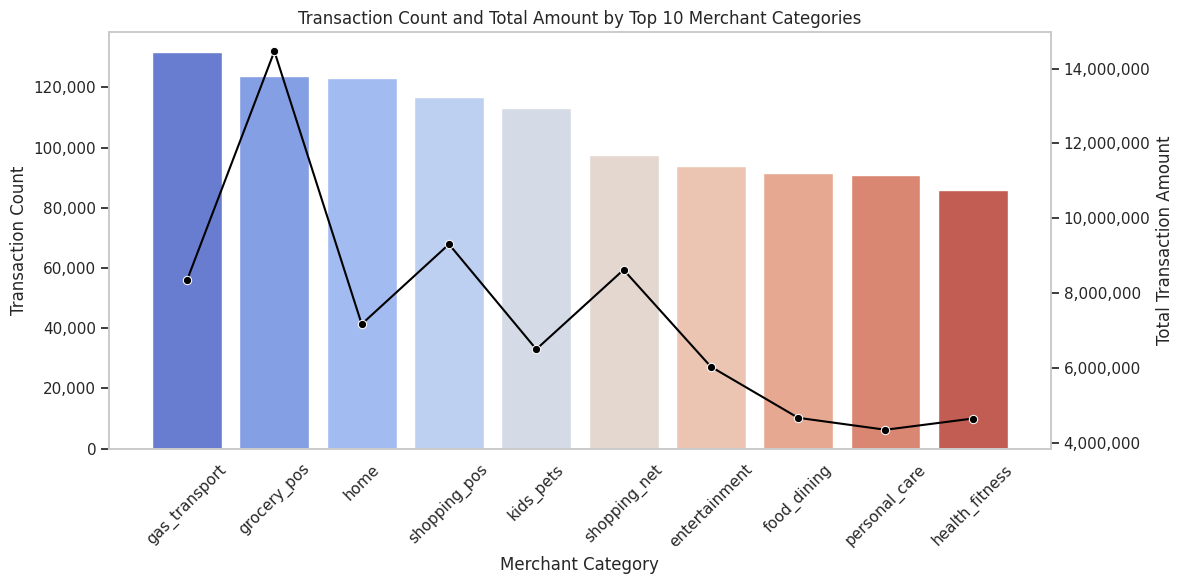

In [0]:
# Visualization 5: Transaction Count and Total Amount by Merchant Category (Top 10 Categories)

# Group by category and calculate transaction count and total amount
top_categories = pandas_df.groupby('category').agg(
    transaction_count=('trans_num', 'count'),
    total_amount=('amt', 'sum')
).nlargest(10, 'transaction_count').reset_index()

# Plotting with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot transaction count on the primary y-axis
sns.barplot(x='category', y='transaction_count', data=top_categories, palette='coolwarm', ax=ax1)
ax1.set_ylabel('Transaction Count')
ax1.set_xlabel('Merchant Category')
ax1.set_title('Transaction Count and Total Amount by Top 10 Merchant Categories')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(False)  # Disable grid for primary y-axis

# Create secondary y-axis for total transaction amount
ax2 = ax1.twinx()
sns.lineplot(x='category', y='total_amount', data=top_categories, color='black', marker='o', ax=ax2)
ax2.set_ylabel('Total Transaction Amount')
ax2.grid(False)  # Disable grid for secondary y-axis

# Set y-axis formatting to include thousands separator for clarity
from matplotlib.ticker import FuncFormatter
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Tight layout for better fit
fig.tight_layout()
plt.show()

  Is Fraud    Count  Percentage
0        0  1289169   99.421135
1        1     7506    0.578865
2    Total  1296675  100.000000


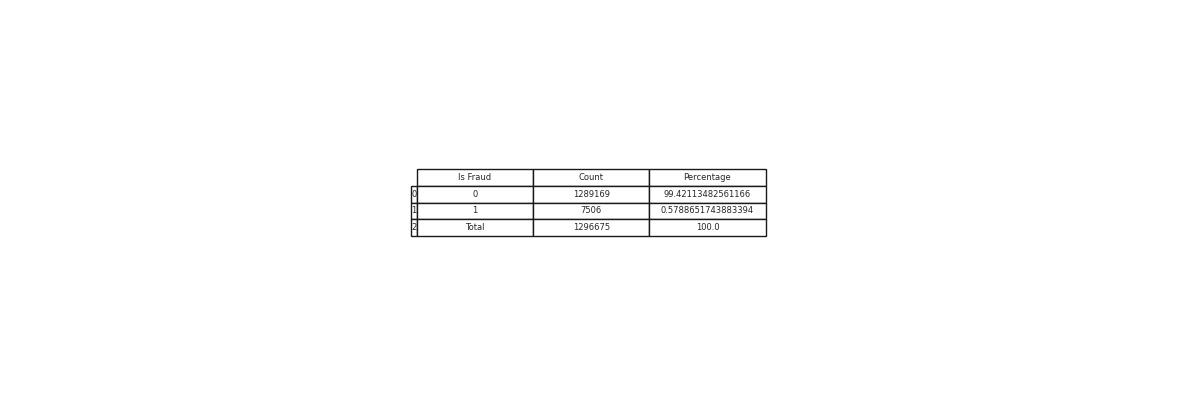

In [0]:
# Visualization 6: Fraudulent and Non-Fraudulent Transactions (Table)

# Calculate counts for fraud and non-fraud transactions
fraud_counts = pandas_df['is_fraud'].value_counts().reset_index()
fraud_counts.columns = ['Is Fraud', 'Count']

# Calculate percentages
total_transactions = pandas_df.shape[0]
fraud_counts['Percentage'] = (fraud_counts['Count'] / total_transactions) * 100

# Add a row for the total values
total_row = pd.DataFrame({'Is Fraud': ['Total'], 'Count': [total_transactions], 'Percentage': [100.0]})
fraud_counts = pd.concat([fraud_counts, total_row], ignore_index=True)

# Display the table
print(fraud_counts)

# Create a figure
fig, ax = plt.subplots(figsize=(15, 5)) # set size frame
ax.axis('tight')
ax.axis('off')
tbl = table(ax, fraud_counts, loc='center', cellLoc='center', colWidths=[0.1]*len(fraud_counts.columns))

# Save the table as an image
plt.savefig('fraud_counts_table.png', bbox_inches='tight')

# Display the image
plt.show()

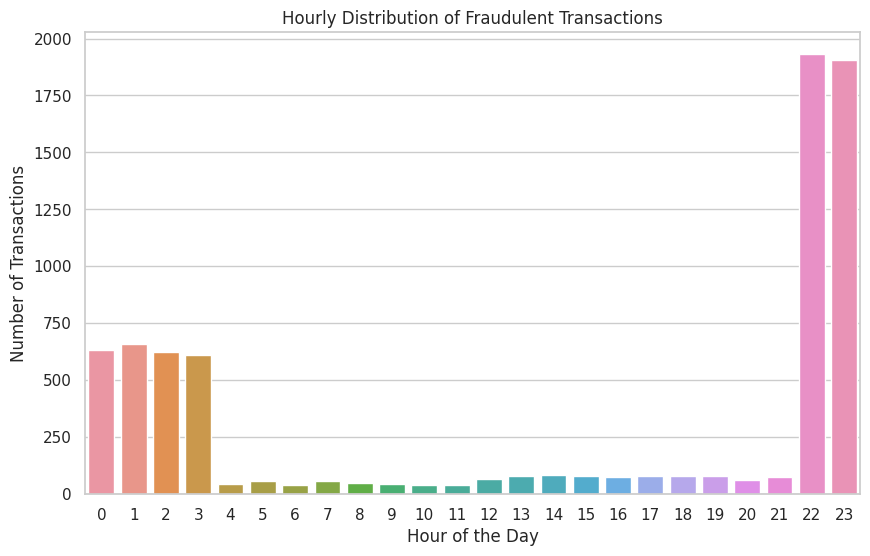

In [0]:
# Visualization 7: Hourly Distribution of Fraudulent Transactions (Barplot)

# Convert the 'trans_date_trans_time' column to datetime
pandas_df['trans_date_trans_time'] = pd.to_datetime(pandas_df['trans_date_trans_time'])

# Filter for fraudulent transactions
fraud_df = pandas_df[pandas_df['is_fraud'] == 1]

# Hourly Transactions
hourly_transactions = fraud_df.groupby(
    fraud_df['trans_date_trans_time'].dt.hour
)['trans_num'].count().reset_index()

# Rename columns for clarity
hourly_transactions.columns = ['Hour', 'Number of Transactions']

# Check if hourly_transactions is empty before plotting
if not hourly_transactions.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Hour', y='Number of Transactions', data=hourly_transactions)
    plt.title('Hourly Distribution of Fraudulent Transactions')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Transactions')
    plt.show()
else:
    print("No fraudulent transactions found.")

In [0]:
# When stopping, use this order:
def clean_spark_stop():
    try:
        spark.sparkContext.stop()
        spark.stop()
        print("Spark stopped successfully")
    except Exception as e:
        print(f"Error stopping Spark: {e}")
        # Force stop on Windows
        if os.name == 'nt':
            os.system('taskkill /f /im java.exe')